In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data

In [3]:
BMMC = sp.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [4]:
print(f"The data has {BMMC.n_obs} observations and {BMMC.n_vars} features.")

The data has 69249 observations and 129921 features.


In [5]:
BMMC

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
BMMC.obs['ATAC_nCount_peaks']

TAGTTGTCACCCTCAC-1-s1d1      4031.0
CTATGGCCATAACGGG-1-s1d1      8636.0
CCGCACACAGGTTAAA-1-s1d1      4674.0
TCATTTGGTAATGGAA-1-s1d1      2803.0
ACCACATAGGTGTCCA-1-s1d1      1790.0
                             ...   
AAACCGCGTTTGAGGC-12-s4d9    10551.0
TGACTTAAGTTCCCGT-12-s4d9    13055.0
GCTGTACCACCGTTCC-12-s4d9     9689.0
ACACTTGCAACTAGAA-12-s4d9    21123.0
CACTTAAAGTCTGGGC-12-s4d9     6877.0
Name: ATAC_nCount_peaks, Length: 69249, dtype: float64

# Train/Test Split

In [7]:
BMMC.obs.drop_duplicates(subset=["DonorID"], keep='first').reset_index()[["Site","DonorID","DonorAge","DonorBMI","DonorBloodType","DonorRace","Ethnicity","DonorGender","QCMeds","DonorSmoker"]].set_index('DonorID').sort_values(by=['DonorID'])

,Site,DonorAge,DonorBMI,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker
DonorID,,,,,,,,,
10886,site1,35,28.6,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
11466,site3,22,31.5,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
12710,site2,27,32.1,O+,White,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
13272,site4,35,31.0,O+,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker
15078,site1,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker
16710,site2,40,27.8,O+,White,HISPANIC OR LATINO,Female,False,Smoker
18303,site1,33,24.0,O+,Asian,NOT HISPANIC OR LATINO,Male,False,Smoker
19593,site4,31,32.6,A+,Black or African American,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
28045,site3,36,23.8,A+,Other Race,HISPANIC OR LATINO,Female,False,Nonsmoker


69249 samples of 10 donors


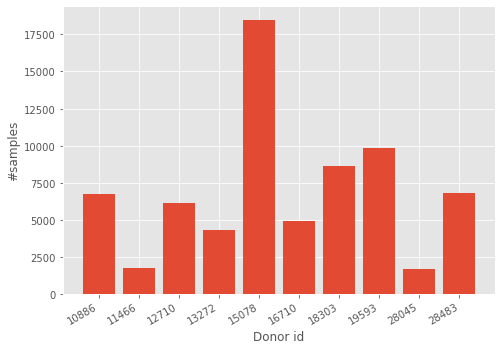

In [8]:
donors, donor_sample_count = np.unique(BMMC.obs['DonorID'], return_counts=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(donor_sample_count)} samples of {len(donors)} donors")
ax.bar(list(map(str, donors)), donor_sample_count)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Donor id")
plt.ylabel("#samples")
plt.show()

In [9]:
test_donors_idx = [19593, 28045, 28483]
test_filter = np.isin(BMMC.obs['DonorID'], test_donors_idx)
train_filter = np.invert(test_filter)

n_train = np.sum(train_filter)
n_test = np.sum(test_filter)
print(f"{n_train} train samples\n{n_test} test samples\n{n_train/(n_train+n_test)*100:.2f}% of samples used for training")

50913 train samples
18336 test samples
73.52% of samples used for training


In [10]:
X_test = BMMC.obsm['ATAC_gene_activity'][test_filter]
X_train = BMMC.obsm['ATAC_gene_activity'][train_filter]

Y_test = BMMC.obs['cell_type'][test_filter]
Y_train = BMMC.obs['cell_type'][train_filter]

In [11]:
Y_train

TAGTTGTCACCCTCAC-1-s1d1     Naive CD20+ B
CTATGGCCATAACGGG-1-s1d1        CD14+ Mono
CCGCACACAGGTTAAA-1-s1d1            CD8+ T
TCATTTGGTAATGGAA-1-s1d1            CD8+ T
ACCACATAGGTGTCCA-1-s1d1        CD16+ Mono
                                ...      
AAACCGCGTTTGAGGC-12-s4d9     CD8+ T naive
TGACTTAAGTTCCCGT-12-s4d9       Lymph prog
GCTGTACCACCGTTCC-12-s4d9           CD8+ T
ACACTTGCAACTAGAA-12-s4d9             cDC2
CACTTAAAGTCTGGGC-12-s4d9    Naive CD20+ B
Name: cell_type, Length: 50913, dtype: category
Categories (22, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

In [12]:
train_donors = BMMC.obs[train_filter]['DonorID']

# Data Visualisation

In [13]:
cell_types = np.unique(BMMC.obs['cell_type'])
print(cell_types)

['B1 B' 'CD14+ Mono' 'CD16+ Mono' 'CD4+ T activated' 'CD4+ T naive'
 'CD8+ T' 'CD8+ T naive' 'Erythroblast' 'G/M prog' 'HSC'
 'ID2-hi myeloid prog' 'ILC' 'Lymph prog' 'MK/E prog' 'NK' 'Naive CD20+ B'
 'Normoblast' 'Plasma cell' 'Proerythroblast' 'Transitional B' 'cDC2'
 'pDC']


50913 samples of 22 cells


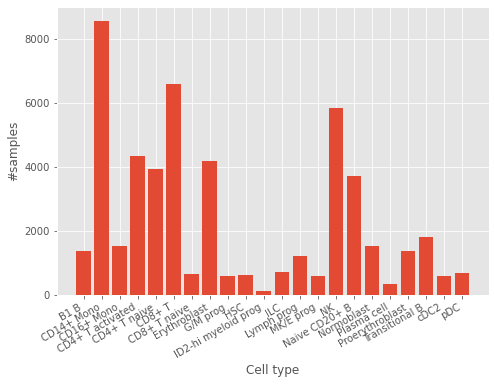

In [14]:
cells, counts = np.unique(Y_train, return_counts=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(counts)} samples of {len(cells)} cells")
ax.bar(cells, counts)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

In [15]:
X_train

<50913x19039 sparse matrix of type '<class 'numpy.float32'>'
	with 268039283 stored elements in Compressed Sparse Column format>

In [16]:
print(f"The sparsity of the train matrix is {(1 - 268039283 / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

The sparsity of the train matrix is 72.35%


# Model Training

In [ ]:
n_folds = 5 # change?

cv = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)

param_grid = {
    'C': [0.01, 1]  # Regularization parameter values to try
}

log_reg = LogisticRegression(max_iter=1000)  # Initializing logistic regression model
gridsearch = GridSearchCV(log_reg, param_grid, n_jobs=-1, cv=cv, verbose=5,
                          return_train_score=True)

gridsearch.fit(X_train, Y_train, groups=train_donors)

In [ ]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print(f'Average training accuracy across folds: {train_score:.3}')
print(f'Average validation accuracy across folds: {validation_score:.3}')

print(f'Best hyperparams: {gridsearch.best_params_}')

In [ ]:
# save best model
with open('lsvm_best_model.pkl','wb') as f:
    pickle.dump(gridsearch.best_estimator_,f)

# Model analysis

In [ ]:
# load model
with open('lsvm_best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [ ]:
test_predictions =  best_model.predict(X_test)
test_predictions

In [ ]:
Y_test

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Test accuracy: {accuracy_score(Y_test, test_predictions)}")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
plt.rcParams['figure.figsize'] = [30, 30]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        test_predictions,
        Y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    plt.xticks(rotation=30, ha='right')
    disp.ax_.set_title(title)

plt.grid(False)
plt.show()

In [ ]:
umap_coordinates = BMMC.obsm['ATAC_umap']

cell_types = np.unique(BMMC.obs['cell_type'])
colors = plt.cm.get_cmap('viridis', len(cell_types))

for i, cell_type in enumerate(cell_types):
    mask = (BMMC.obs['cell_type'] == cell_type)
    plt.scatter(umap_coordinates[mask, 0], umap_coordinates[mask, 1], label=cell_type, color=colors(i), s=10)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot observations')
plt.legend(title='Cell Type')
plt.show()

In [ ]:
all_predictions = best_model.predict(BMMC.obsm['ATAC_gene_activity'])
all_predictions

In [ ]:
for i, cell_type in enumerate(cell_types):
    mask = (all_predictions == cell_type)
    plt.scatter(umap_coordinates[mask, 0], umap_coordinates[mask, 1], label=cell_type, color=colors(i), s=10)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot predictions')
plt.legend(title='Cell Type')
plt.show()

In [ ]:
RightPred_mask = (all_predictions == BMMC.obs['cell_type'])
plt.scatter(umap_coordinates[RightPred_mask, 0], umap_coordinates[RightPred_mask, 1], label="Right prediction", color='green', s=10)
plt.scatter(umap_coordinates[np.invert(RightPred_mask), 0], umap_coordinates[np.invert(RightPred_mask), 1], label="Wrong Prediction", color='red', s=10)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot prediction accuracy')
plt.legend(title='Cell Type')
plt.show()

In [ ]:
main_cell_types = {
    'B Cells': ['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell'],
    'T Cells': ['CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive'],
    'Monocytes/Macrophages': ['CD14+ Mono', 'CD16+ Mono'],
    'Myeloid Progenitors': ['G/M prog' , 'ID2-hi myeloid prog'],
    'Erythroid Cells': ['Erythroblast', 'Normoblast', 'Proerythroblast'],
    'Dendritic cells': ['cDC2', 'pDC']
}

main_cell_types_mapping = {x:k for k,v in main_cell_types.items() for x in v}
for missing_cell_type in set(cell_types) - set(main_cell_types_mapping.keys()):
    main_cell_types_mapping[missing_cell_type] = missing_cell_type
main_cell_types_mapping

In [ ]:
RightPred_mask = (all_predictions == BMMC.obs['cell_type'])
MainCellTypePred_mask = np.logical_and(
(np.vectorize(main_cell_types_mapping.get)(all_predictions) == np.vectorize(main_cell_types_mapping.get)(BMMC.obs['cell_type'])),
np.invert(RightPred_mask)
)
WrongPred_Mask = np.invert(np.logical_or(RightPred_mask, MainCellTypePred_mask))

plt.scatter(umap_coordinates[RightPred_mask, 0], umap_coordinates[RightPred_mask, 1], label="Right prediction", color='green', s=10)
plt.scatter(umap_coordinates[MainCellTypePred_mask, 0], umap_coordinates[MainCellTypePred_mask, 1], label="Right Main Cell Type prediction", color='blue', s=10)
plt.scatter(umap_coordinates[WrongPred_Mask, 0], umap_coordinates[WrongPred_Mask, 1], label="Wrong Prediction", color='red', s=10)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot prediction accuracy')
plt.legend(title='Cell Type')
plt.show()